In [2]:
rm(list= ls())
ls()

character(0)

In [4]:
suppressPackageStartupMessages({
#import library
library(Seurat)
library(harmony)
library(tidyverse)
library(cowplot)
library(patchwork)
library(WGCNA)
library(hdWGCNA)
# library(UCell)
library(ggplot2)
library(ggrepel)
library(pheatmap)
    library(RColorBrewer)
library(igraph)})


# hdwgcna

In [5]:
degs<-read.csv("/hsfscqjf1/ST_CQ/P24Z32300N0020/hemingmin/bom/10.sn_merged2/results/4_timepoint_degs/all/all.marekr.csv")

In [58]:
sc<-readRDS(file = "../2_anno/singlR/anno.rds")

In [59]:
sce<-sc[degs$gene,]

In [61]:
# 1.Set up Seurat object for WGCNA
seurat_obj <- SetupForWGCNA(
  sce, 
  gene_select = "fraction", # the gene selection approach
  fraction = 0.05, # fraction of cells that a gene needs to be expressed in order to be included
  wgcna_name = "degs_timepoint" # the name of the hdWGCNA experiment
)

Warning message in SetupForWGCNA(sce, gene_select = "fraction", fraction = 0.05, :
“440 features selected. You may wish to change the settings to include more features in your analysis.”


In [62]:
length(seurat_obj@misc$degs_timepoint$wgcna_genes)

[1] 440

In [63]:
seurat_obj

An object of class Seurat 
440 features across 125717 samples within 1 assay 
Active assay: RNA (440 features, 0 variable features)
 2 layers present: counts, data
 5 dimensional reductions calculated: pca, pca_harmony, pca_harmony_batch, pca_harmony_sample, umap

In [69]:
seurat_obj <- MetacellsByGroups(
  seurat_obj = seurat_obj,
  group.by = c("sample"), # specify the columns in seurat_obj@meta.data to group by
  k = 50, # nearest-neighbors parameter  
  max_shared = 10, # maximum number of shared cells between two metacells  
  ident.group = 'sample' # set the Idents of the metacell seurat object
)

# normalize metacell expression matrix:
seurat_obj <- NormalizeMetacells(seurat_obj)

In [72]:
metacell_obj <- GetMetacellObject(seurat_obj)

In [74]:
# 3.Co-expression network analysis
# 3.1 Set up the expression matrix
seurat_obj <- SetDatExpr(
  seurat_obj,
  #group_name = c("Cell_morphogenesis"), # the name of the group of interest in the group.by column 
  #group.by="celltype_level2_v3", # the metadata column containing the cell type info. This same column should have also been used in MetacellsByGroups
  assay = "RNA", # using SCT or RNA assay
  slot = "data"# using normalized data
)

pickSoftThreshold: will use block size 440.
 pickSoftThreshold: calculating connectivity for given powers...
   ..working on genes 1 through 440 of 440
   Power SFT.R.sq   slope truncated.R.sq mean.k. median.k. max.k.
1      1  0.14900  2.4200         0.3760  240.00    259.00  276.0
2      2  0.09320  0.9500         0.1750  160.00    172.00  212.0
3      3  0.08960  0.6250        -0.1700  117.00    121.00  174.0
4      4  0.11800  0.3970         0.0342   90.30     88.90  146.0
5      5  0.05890  0.1960         0.1070   71.40     66.10  125.0
6      6  0.00688  0.0461         0.3850   57.50     52.70  108.0
7      7  0.01330 -0.0575         0.4670   47.00     44.10   93.1
8      8  0.08090 -0.1270         0.7900   38.70     36.50   80.9
9      9  0.18400 -0.2180         0.6310   32.20     31.00   70.6
10    10  0.30300 -0.3050         0.7090   27.00     26.50   61.8
11    12  0.46900 -0.4150         0.7950   19.40     19.10   48.0
12    14  0.48900 -0.5400         0.7530   14.30     13.

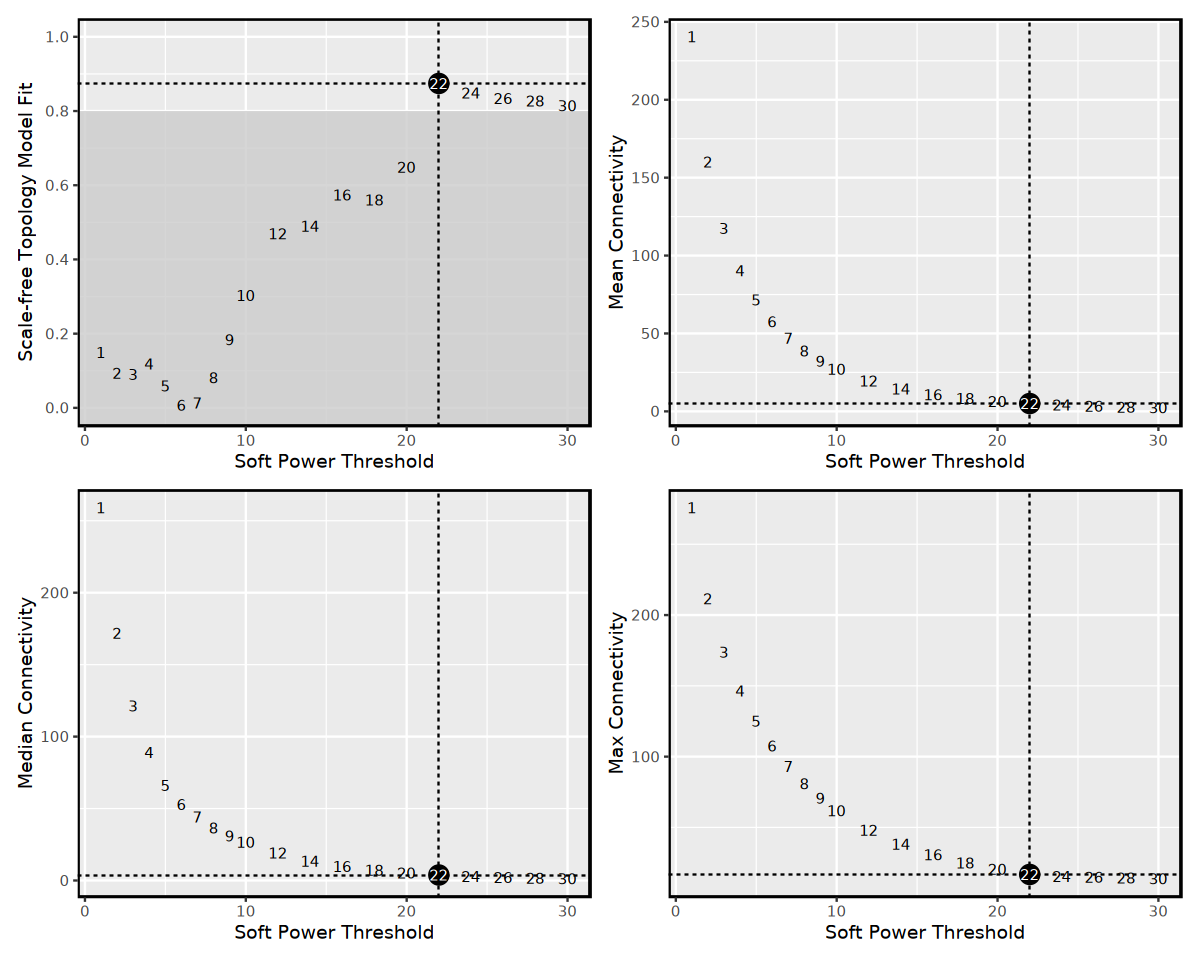

In [75]:
# 3.2 Select soft-power threshold
options(repr.plot.width = 10, repr.plot.height=8)
# Test different soft powers:
seurat_obj <- TestSoftPowers(
  seurat_obj,
  networkType = 'signed' # you can also use "unsigned" or "signed hybrid"
)

# plot the results:
plot_list <- PlotSoftPowers(seurat_obj)

# assemble with patchwork
wrap_plots(plot_list, ncol=2)

In [76]:
pdf("pickSoftThreshold.pdf", width = 15, height = 8)
wrap_plots(plot_list, ncol = 2)
dev.off()

png 
  2

In [77]:
power_table <- GetPowerTable(seurat_obj)

In [78]:
power_table$Power[which(power_table$SFT.R.sq >= 0.8)]

[1] 22 24 26 28 30

In [80]:
# construct co-expression network:
seurat_obj <- ConstructNetwork(
  seurat_obj, soft_power=22,
  setDatExpr=FALSE,
  tom_name = 'all_degs_Matrix' # name of the topoligical overlap matrix written to disk
)

 Calculating consensus modules and module eigengenes block-wise from all genes
 Calculating topological overlaps block-wise from all genes
   Flagging genes and samples with too many missing values...
    ..step 1
    TOM calculation: adjacency..
    ..will not use multithreading.
     Fraction of slow calculations: 0.000000
    ..connectivity..
    ..matrix multiplication (system BLAS)..
    ..normalization..
    ..done.
 ..Working on block 1 .
 ..Working on block 1 .
 ..merging consensus modules that are too close..


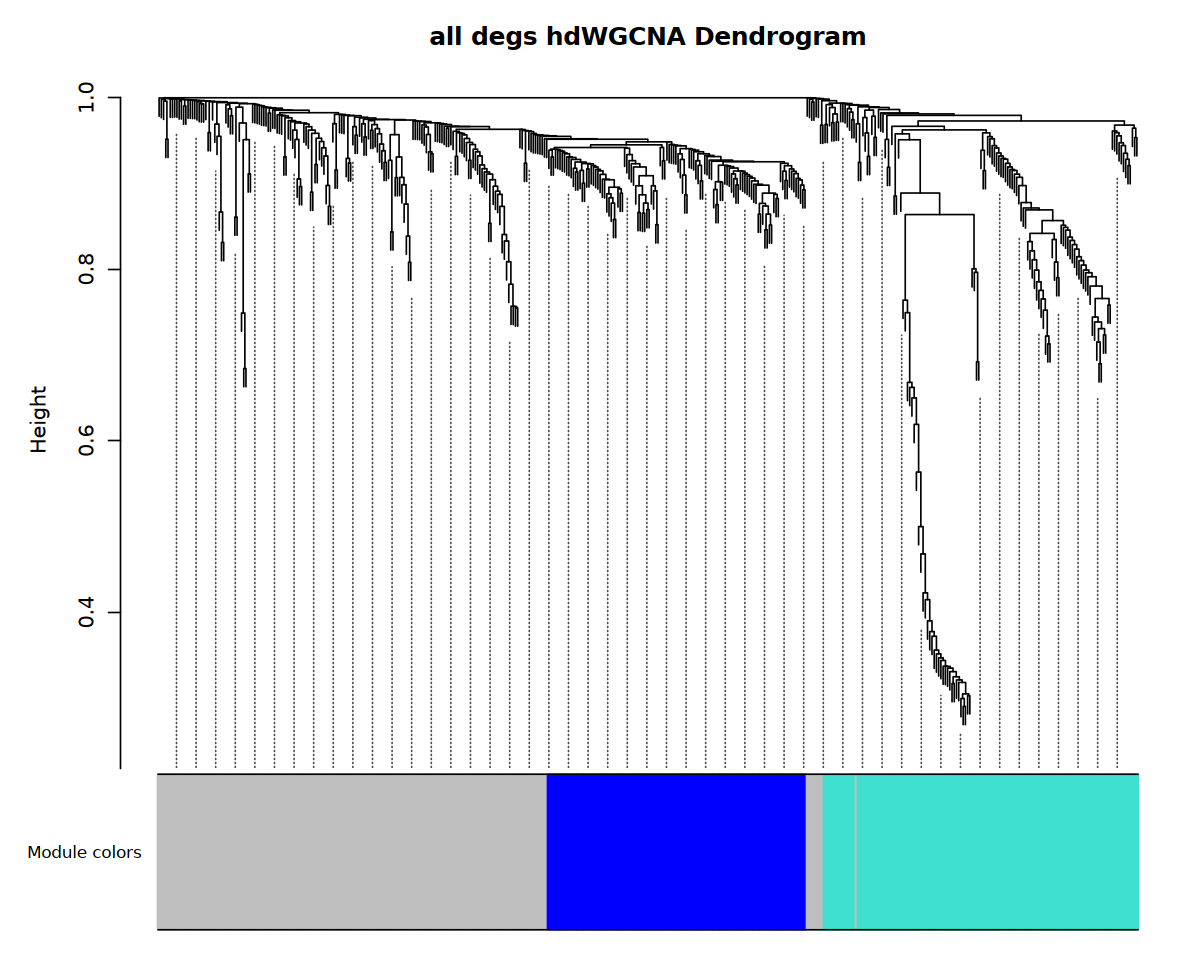

In [81]:
PlotDendrogram(seurat_obj, main='all degs hdWGCNA Dendrogram')

In [82]:
seurat_obj@misc$degs_timepoint$wgcna_modules %>% head
table(seurat_obj@misc$degs_timepoint$wgcna_modules$module)

,gene_name,module,color
,<chr>,<fct>,<chr>
LOC101738162,LOC101738162,turquoise,turquoise
CPH24,CPH24,turquoise,turquoise
CPR46,CPR46,turquoise,turquoise
CPH25,CPH25,turquoise,turquoise
CPH34,CPH34,turquoise,turquoise
LOC101738434,LOC101738434,turquoise,turquoise



turquoise      grey      blue 
      140       184       116 

In [83]:
pdf("all_degs_hdWGCNA_Dendrogram.pdf", width = 15, height = 8)
PlotDendrogram(seurat_obj, main='all degs hdWGCNA Dendrogram')
dev.off()

png 
  2

In [84]:
#Optional: inspect the topoligcal overlap matrix (TOM)  ##只是看看tom矩阵
TOM <- GetTOM(seurat_obj)
# head(TOM)

In [85]:
VariableFeatures(seurat_obj)

character(0)

In [86]:
# 4.1 Compute harmonized module eigengenes
seurat_obj <- ScaleData(seurat_obj, features=seurat_obj@misc$degs_timepoint$wgcna_genes)

Centering and scaling data matrix



In [87]:
# compute all MEs in the full single-cell dataset
seurat_obj <- ModuleEigengenes(
 seurat_obj,
 group.by.vars="timepoint"  
)

[1] "turquoise"


Centering and scaling data matrix

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcaturquoise to pcaturquoise_”
pcaturquoise_ 1 
Positive:  LOC101735763, CSP4, fmxg9M19, CSP1, CPG16, CPR42, LOC101739260, GSTs1, LOC101746878, LOC100141506 
	   LOC692632, CPR53, Pp, CPH24, CPR32, CPT1, CPH25, CPG17, LOC101738434, CPG4 
	   LOC101738162, CPH34, LOC101741978, CPR127, CPR34, CPR28, CPR38, CPR41, LOC100134928, CPR5 
Negative:  Inx2, LOC101745123, Crabp, LOC101743966, CLIP11, CatD, LOC101746693, LOC101740962, LOC101735576, Pdi 
	   LOC100037426, LOC100862837, LOC101739504, SPARC, LOC101735445, Fah, LOC101740330, os, LOC733001, LOC778526 
	   LOC101740863, LOC732949, LOC119628334, LOC101742452, LOC778457, LOC101741531, LOC101742383, Hsp90, LOC101744379, LOC101740099 
pcaturquoise_ 2 
Positive:  CPR41, CPR4, CPR38, CPR5, CPR2, CPG4, CPG5, CPR3, LOC101741978, CPR34 
	   LOC101739926, CPR127, CPH34, LOC101743521, CPR46, LOC1017406

[1] "grey"


Centering and scaling data matrix

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcagrey to pcagrey_”
pcagrey_ 1 
Positive:  LOC732932, Sqd, Hsc70-4, AnnIX, LOC100101180, LOC101743323, PFN, Pabp, Ybp, LOC101746121 
	   GSTd2, LOC101737919, LOC119629027, Sui1, LOC101742474, LOC100101161, Fkbp45, LOC101741956, LOC733028, LOC101743511 
	   LOC732866, LOC101742289, Rabb, LOC101747020, Sop2, LOC101742624, LOC101744203, LOC101735495, Lark, LOC101737399 
Negative:  LOC101740648, LOC119631129, LOC101736853, LOC101741553, LOC101745162, glv4-like, Lzm, LOC101740714, CLIP3, LOC101743336 
	   LOC692743, CCE-un1, Leb3, LOC101737256, LOC101738295, Ldh, Grf, CPR21, LOC110386217, NGR-B1 
	   LOC101741233, LOC101737430, Let-2, Ldlr, LOC692392, CecA, LOC101745606, LOC101746512, LOC101742792, LOC101741882 
pcagrey_ 2 
Positive:  LOC101742445, LOC101739863, DnaJ-5, Samui, LOC101737576, PH, LOC101737399, LOC101737178, LOC101740600, LOC10173

[1] "blue"


Centering and scaling data matrix

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcablue to pcablue_”
pcablue_ 1 
Positive:  Cbz, LOC101745102, LOC100101174, LOC101738402, LOC101736630, LOC100101209, Anxb13, LOC101738514, LOC101742358, LOC101735454 
	   LOC778502, LOC101735777, LOC101735654, LOC101743180, LOC101737032, LOC101742699, LOC101737540, LOC733012, Rel, LOC732926 
	   LOC101745117, LOC101740283, LOC101744433, LOC101746299, LOC101736214, LOC101739346, LOC101743802, LOC101737452, E75, dcr-2 
Negative:  LOC119630575, LOC101742570, LOC101739106, E74, LOC101741350, LOC101736335, LOC101739010, LOC101740476, LOC119629948, LOC101736354 
	   LOC101745835, LOC101741339, LOC101742811, LOC101746243, LOC101743013, LOC101738805, LOC101737365, LOC101739334, LOC101739890, LOC101746057 
	   LOC101736835, LOC101743890, LOC101735359, LOC101741546, LOC101738787, Gata-beta, LOC101746352, LOC101742794, LOC119629754, LOC101735956 
pc

In [88]:
# harmonized module eigengenes:
hMEs <- GetMEs(seurat_obj) 
head(hMEs)
# module eigengenes:
MEs <- GetMEs(seurat_obj, harmonized=FALSE)
head(MEs)

,turquoise,grey,blue
,<dbl>,<dbl>,<dbl>
CELL1_N1_1,-2.2414896,-1.808817,-2.3204335
CELL2_N1_1,-1.7705397,-2.398862,-2.4273368
CELL3_N1_1,-4.4215918,-3.640885,-2.7142365
CELL4_N1_1,-0.3447947,1.816243,-0.8067831
CELL5_N1_1,8.9536738,2.345325,-1.4964742
CELL6_N1_1,4.4868584,10.186810,7.2608948


,turquoise,grey,blue
,<dbl>,<dbl>,<dbl>
CELL1_N1_1,-1.1838592,-2.78329361,-3.292732
CELL2_N1_1,-0.8930861,-3.37975698,-3.477736
CELL3_N1_1,-3.6337275,-4.56387735,-3.683990
CELL4_N1_1,0.8572052,1.04487097,-1.954956
CELL5_N1_1,10.4218625,0.06843953,-2.486834
CELL6_N1_1,5.6075523,8.94723272,3.608306


In [89]:
# 4.2 Compute module connectivity
# compute eigengene-based connectivity (kME):
seurat_obj <- ModuleConnectivity(seurat_obj)

In [90]:
# rename the modules
seurat_obj <- ResetModuleNames(
  seurat_obj,
  new_name = "all_degs-M"
)

[1] "all_degs-M1"
[1] "all_degs-M2"
[1] "all_degs-M1"
[1] "all_degs-M2"


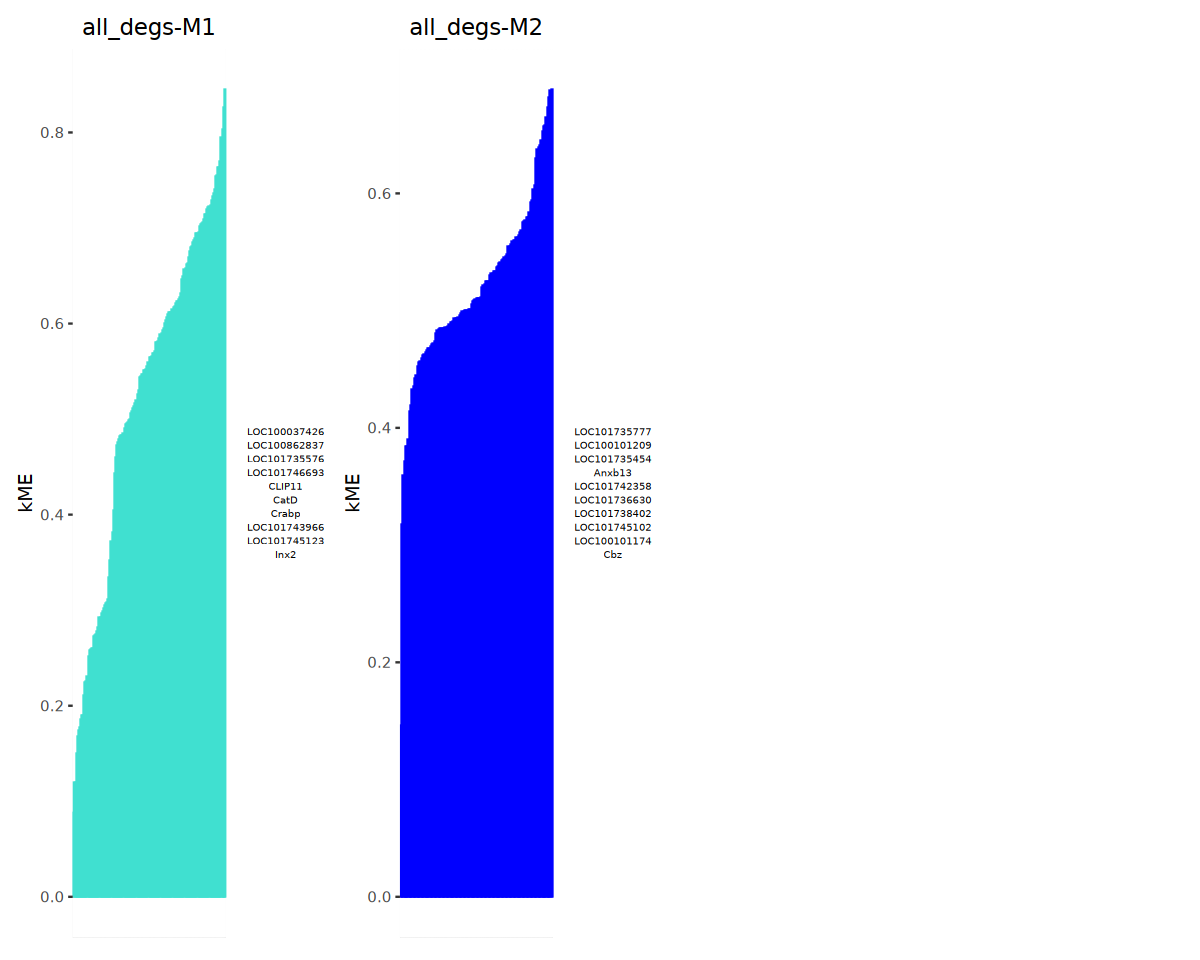

In [91]:
# plot genes ranked by kME for each module
p <- PlotKMEs(seurat_obj, ncol=4)

p

In [92]:
ggsave(filename = "kME_module_gene_rank.pdf", plot = p, width = 10, height = 8, dpi = 300)

In [93]:
# get the module assignment table:
modules <- GetModules(seurat_obj)


head(modules)

,gene_name,module,color,kME_all_degs-M1,kME_grey,kME_all_degs-M2
,<chr>,<fct>,<chr>,<dbl>,<dbl>,<dbl>
LOC101738162,LOC101738162,all_degs-M1,turquoise,0.2586003,0.07387519,-0.008699053
CPH24,CPH24,all_degs-M1,turquoise,0.2246847,0.03329893,-0.029544690
CPR46,CPR46,all_degs-M1,turquoise,0.3338208,0.06722786,-0.026650845
CPH25,CPH25,all_degs-M1,turquoise,0.2574492,0.02993874,-0.035313492
CPH34,CPH34,all_degs-M1,turquoise,0.2780503,0.03302386,-0.038983588
LOC101738434,LOC101738434,all_degs-M1,turquoise,0.2603369,0.09857756,0.012978550


In [94]:
# get hub genes
hub_df <- GetHubGenes(seurat_obj, n_hubs = 100)

In [95]:
write.csv(hub_df,"hub_df_100.csv") #hub 100 genes

In [96]:
saveRDS(seurat_obj, file='hdWGCNA_object.rds')

In [5]:
seurat_obj<<-readRDS(file='hdWGCNA_object.rds')

In [6]:
# make a featureplot of hMEs for each module
# plot_list <- ModuleFeaturePlot(
#   seurat_obj,
#   features='hMEs', # plot the hMEs
#   order=TRUE # order so the points with highest hMEs are on top
# )

# # stitch together with patchwork
# wrap_plots(plot_list, ncol=2)

In [7]:
# pdf("ModuleFeaturePlot.pdf", width = 15, height = 8)
# wrap_plots(plot_list, ncol=2)
# dev.off()

In [8]:
# get hMEs from seurat object
MEs <- GetMEs(seurat_obj, harmonized=TRUE)
mods <- colnames(MEs); mods <- mods[mods != 'grey']

# add hMEs to Seurat meta-data:
seurat_obj@meta.data <- cbind(seurat_obj@meta.data, MEs)

In [9]:
ls()

[1] "MEs"        "mods"       "seurat_obj"

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


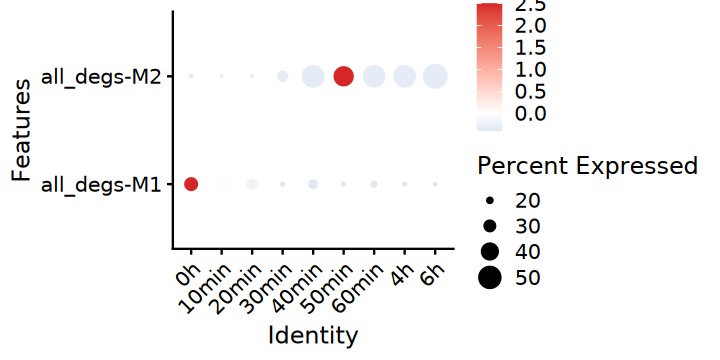

In [11]:
# plot with Seurat's DotPlot function
p <- DotPlot(seurat_obj, features=mods, group.by = 'timepoint')

# flip the x/y axes, rotate the axis labels, and change color scheme:
p <- p +
  coord_flip() +
  RotatedAxis() +
  scale_color_gradient2(low = "#1f77b4", mid = "white", high = "#d62728")

# plot output
width=6
height=3
options(repr.plot.width = width, repr.plot.height=height)
p

In [12]:
ggsave(filename = "DotPlot_timepoint.pdf", plot = p, width = 6, height = 3)

In [32]:
table(Idents(seurat_obj)<-seurat_obj$celltype)


         Apoptosis Cell_morphogenesis          Cuticle_1          Cuticle_2 
             13646              26040               5801               2884 
      Epithelial_1             Immune 
             23933              53413 

In [37]:
seurat_obj$celltype <- factor(seurat_obj$celltype, levels = c("Apoptosis","Immune","Cell_morphogenesis", "Epithelial_1","Cuticle_1","Cuticle_2"))

In [43]:
# saveRDS(seurat_obj,file = "hdwgcna.rds")

In [45]:
mods

[1] "all_degs-M1" "all_degs-M2"

In [105]:
colnames(seurat_obj@meta.data)

[1] "orig.ident"        "nCount_RNA"        "nFeature_RNA"     
 [4] "seq_folder"        "nUMI"              "nGene"            
 [7] "doublet_info"      "library"           "log10GenesPerUMI" 
[10] "mitoRatio"         "cells"             "sample"           
[13] "timepoint"         "batch"             "leiden_res0.4"    
[16] "cluster"           "leiden_res0.2"     "leiden_res0.5"    
[19] "leiden_res0.6"     "leiden_res0.8"     "leiden_res1"      
[22] "leiden_res0.3"     "celltype"          "metacell_grouping"
[25] "all_degs-M1"       "grey"              "all_degs-M2"

In [107]:
write.csv(modules,"modules.csv")

In [108]:
mods <- unique(seurat_obj@misc$degs_timepoint$wgcna_modules$module)
mods <- mods[mods != "grey"]

In [109]:
seurat_obj<-readRDS(file='hdWGCNA_object.rds')

In [110]:
ModuleNetworkPlot(
  seurat_obj,
  outdir = 'ModuleNetworks'
)

Writing output files to ModuleNetworks

Selecting by kME_all_degs-M1
Selecting by kME_all_degs-M2


[1] "all_degs-M1"
[1] "all_degs-M2"


In [137]:
# levels(modules$module)
str(mods[1:2])

 chr [1:2] "all_degs-M1" "all_degs-M2"


In [139]:
# get the list of modules:
modules <- GetModules(seurat_obj)
mods <- levels(modules$module); mods <- mods[mods != 'grey']

In [141]:
mods

[1] "all_degs-M1" "all_degs-M2"

In [145]:
# hubgene network
pdf("HubGeneNetworkPlot.pdf", width = 5, height = 5)
modules <- GetModules(seurat_obj)
mods <- levels(modules$module)
mods <- mods[mods != 'grey']

p<-HubGeneNetworkPlot(
  seurat_obj,
  n_hubs = 5, n_other=10,
    hub.vertex.size = 4,
    edge.alpha =1,
  edge_prop = 0.75,
  mods = "all"
)

dev.off()
# g <- HubGeneNetworkPlot(seurat_obj,  return_graph=TRUE)

Selecting by kME_all_degs-M1
Selecting by kME_all_degs-M2



all_degs-M1        grey all_degs-M2 
         15          10          14 
[1] "turquoise" "blue"      "grey90"    "grey"     
[1] "here"
[1] 486   4


png 
  2